## Notice: 

1.   Please add data augmentation code by yourself!
2.   Download submission.csv and submit to Kaggle


---










In [38]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from glob import glob
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models, utils
from sklearn.model_selection import train_test_split
import pandas as pd
import imgaug.augmenters as iaa
import imgaug as ia
import seaborn as sns

#### Download dataset

In [39]:
# from google.colab import drive
# drive.mount('/content/drive')

In [40]:
# unzip dataset file 
# Plase Modify to your own file path!!!! 
#!unzip -q '/content/drive/MyDrive/MedAI/Week 5/pneumonia-kaggle.zip'

Unzip pneumonia-kaggle.zip from my pc directory

In [41]:
# import zipfile
# with zipfile.ZipFile(r'C:\Users\jeffr\OneDrive\桌面\yzu\neural networks and deep learning\Week 5\pneumonia-kaggle.zip', 'r') as zip_ref:
#     zip_ref.extractall(r'C:\Users\jeffr\OneDrive\桌面\yzu\neural networks and deep learning\Week 5\dataset_kaggle')

#### Prepare dataset


In [42]:
IMG_SIZE = 200
BATCH_SIZE = 64

all_class = ['normal', 'bacteria', 'virus']
class_map = {cls:i for i,cls in enumerate(all_class)} #  'normal':0, 'bacteria': 1, 'virus':2
class_map

{'normal': 0, 'bacteria': 1, 'virus': 2}

In [43]:
# read all paths
img_paths_all = glob('../dataset_kaggle/pneumonia-kaggle/train/*/*.jpeg')
img_paths_test = sorted(glob('../dataset_kaggle/pneumonia-kaggle/test/*.jpeg'))
img_paths_train, img_paths_val = train_test_split(img_paths_all, test_size=0.2)

In [44]:
# number of images
len(img_paths_train), len(img_paths_val), len(img_paths_test)

(4172, 1044, 624)

# Generate data and data augumentation 

In [45]:
class DataGenerator(utils.Sequence):
    def __init__(self, paths, batch_size, img_size, mode='train',aug=False,shuffle = False):
        self.paths = paths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.paths))
        all_class = ['normal', 'bacteria', 'virus']
        self.class_map = {cls:i for i,cls in enumerate(all_class)}
        self.num_classes = len(self.class_map)
        self.img_size = img_size
        self.mode = mode
        self.aug = aug
        aug = iaa.pillike.FilterSharpen() #sharpen images
        self.seq = iaa.Sequential([
            iaa.Fliplr(0.5), # 50% horizontal flip
            iaa.Affine(
                shear=(-16,16), # random shear -16 ~ +16 degree
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale x, y: 80%~120%
                translate_px={"x": (-20, 20), "y": (-20, 20)}, # Translate images by -20 to 20 pixels on x- and y-axis independently 
            ),
        ])
        self.on_epoch_end()

    def __len__(self):
        'number of batches per epoch'
        return int(np.ceil(len(self.paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        idxs = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        # Find list of IDs
        batch_paths = [self.paths[i] for i in idxs]
        # Generate data
        return self.__data_generation(batch_paths)

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, paths):
        """
        Generates data containing batch_size samples
        """
        x = np.empty((len(paths), self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.empty((len(paths)))

        for i, path in enumerate(paths):
            img = cv2.imread(path)[:,:,::-1]
            # img preprocess
            img = cv2.resize(img, (self.img_size, self.img_size))
            ######### Modify your preprocess 前處理請依選用模型定義 !!!!!! ##########
            #img = tf.keras.applications.VGG19.preprocess_input(img) # vgg19 doesn't need to preprocess inputs
            if self.mode != 'test':
                # read class label
                cls = path.split(os.sep)[-2].lower()
                if cls == 'pneumonia':
                    # get filename
                    filename = path.split(os.sep)[-1]
                    # get pneumonia subclass
                    cls_pneumonia = filename.split('_')[1] 
                    cls_idx = class_map[cls_pneumonia]
                # for normal class
                else:
                    cls_idx = class_map[cls]
                y[i] = cls_idx
            x[i] = img

        if self.mode != 'test':            
            # one-hot encoding
            y = tf.keras.utils.to_categorical(y, num_classes=self.num_classes)
            return x, y
        else:
            return x

In [46]:
gen_train = DataGenerator(img_paths_train, BATCH_SIZE, IMG_SIZE, mode='train', aug=True, shuffle = True)
gen_val = DataGenerator(img_paths_val, BATCH_SIZE, IMG_SIZE, mode='val', aug=True, shuffle = True)
gen_test = DataGenerator(img_paths_test, BATCH_SIZE, IMG_SIZE, mode='test')

### Build model with Vgg19 as base model is better than inceptionv3 but takes longer to train with the same epoch

In [47]:
tf.keras.backend.clear_session()

base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
#x = layers.GlobalMaxPool2D()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.BatchNormalization()(x)
# x = layers.Dense(256, activation='relu')(x)
# x = layers.BatchNormalization()(x)
x = layers.Dense(100, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.BatchNormalization()(x)
pred = layers.Dense(3, activation='softmax')(x)

for l in base_model.layers: #freeze Vgg19 all layers
    l.trainable = False
model3 = models.Model(base_model.input,pred)

In [48]:
model = model3
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

#### Training apply learning rate scheduler

In [49]:
def scheduler(epoch, lr):
       if epoch < 20:
            return lr
       else:
            return lr * tf.math.exp(-0.1) # after 20 epoches learning rate will be calculated with this formula

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(0.01),
              metrics=['accuracy'])

Use callbacks, early stopping and learning rate scheduler 

In [50]:
callbacks=[tf.keras.callbacks.EarlyStopping(patience=20,restore_best_weights=True), tf.keras.callbacks.LearningRateScheduler(scheduler)] 

In [51]:
batch_size=32
logs = model.fit(gen_train,batch_size=32,
                steps_per_epoch=len(gen_train) / batch_size,
                callbacks = callbacks,
                epochs=120, 
                verbose=1,
                validation_data=(gen_val))

Epoch 1/120
2/2 [==============================] - 77s 67s/step - loss: 1.6051 - accuracy: 0.5365 - val_loss: 18.4481 - val_accuracy: 0.4875 - lr: 0.0100
Epoch 2/120
2/2 [==============================] - 75s 66s/step - loss: 0.8685 - accuracy: 0.7708 - val_loss: 13.9176 - val_accuracy: 0.6973 - lr: 0.0100
Epoch 3/120
2/2 [==============================] - 72s 63s/step - loss: 0.6202 - accuracy: 0.7708 - val_loss: 73.1757 - val_accuracy: 0.5048 - lr: 0.0100
Epoch 4/120
2/2 [==============================] - 67s 59s/step - loss: 0.6576 - accuracy: 0.7188 - val_loss: 31.7379 - val_accuracy: 0.6494 - lr: 0.0100
Epoch 5/120
2/2 [==============================] - 65s 58s/step - loss: 0.5997 - accuracy: 0.7500 - val_loss: 12.6030 - val_accuracy: 0.6820 - lr: 0.0100
Epoch 6/120
2/2 [==============================] - 65s 57s/step - loss: 0.5716 - accuracy: 0.7344 - val_loss: 20.7415 - val_accuracy: 0.3812 - lr: 0.0100
Epoch 7/120
2/2 [==============================] - 63s 55s/step - loss: 0.74

#### Training logs

In [52]:
history = logs.history
min_loss_epoch = np.argmin(history['val_loss'])
print('val loss ', history['val_loss'][min_loss_epoch])
print('val acc', history['val_accuracy'][min_loss_epoch])

val loss  0.47395581007003784
val acc 0.790229856967926


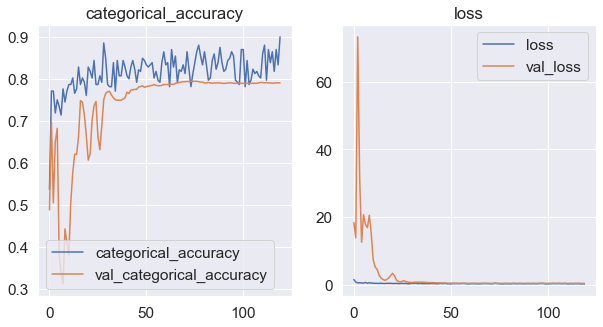

In [53]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['categorical_accuracy', 'val_categorical_accuracy'])
plt.title('categorical_accuracy')
plt.subplot(1,2,2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')
plt.show()

#### Metrics

In [54]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.array([])
y_true = np.array([])
for x_val, y_val in tqdm(gen_val):
    pred = model.predict(x_val)
    y_pred = np.append(y_pred, np.argmax(pred, axis=-1))
    y_true = np.append(y_true, np.argmax(y_val, axis=-1))

  0%|          | 0/17 [00:00<?, ?it/s]

2/2 [==============================] - 4s 2s/step


  6%|▌         | 1/17 [00:04<01:15,  4.71s/it]

2/2 [==============================] - 4s 2s/step


 12%|█▏        | 2/17 [00:10<01:19,  5.32s/it]

2/2 [==============================] - 4s 2s/step


 18%|█▊        | 3/17 [00:15<01:15,  5.37s/it]

2/2 [==============================] - 4s 2s/step


 24%|██▎       | 4/17 [00:21<01:11,  5.47s/it]

2/2 [==============================] - 4s 2s/step


 29%|██▉       | 5/17 [00:26<01:02,  5.23s/it]

2/2 [==============================] - 4s 2s/step


 35%|███▌      | 6/17 [00:31<00:56,  5.11s/it]

2/2 [==============================] - 4s 2s/step


 41%|████      | 7/17 [00:36<00:51,  5.17s/it]

2/2 [==============================] - 4s 2s/step


 47%|████▋     | 8/17 [00:41<00:47,  5.27s/it]

2/2 [==============================] - 3s 2s/step


 53%|█████▎    | 9/17 [00:46<00:39,  4.98s/it]

2/2 [==============================] - 4s 2s/step


 59%|█████▉    | 10/17 [00:51<00:35,  5.11s/it]

2/2 [==============================] - 4s 2s/step


 65%|██████▍   | 11/17 [00:56<00:30,  5.12s/it]

2/2 [==============================] - 3s 2s/step


 71%|███████   | 12/17 [01:00<00:24,  4.81s/it]

2/2 [==============================] - 4s 2s/step


 76%|███████▋  | 13/17 [01:06<00:19,  4.95s/it]

2/2 [==============================] - 4s 2s/step


 82%|████████▏ | 14/17 [01:11<00:14,  4.98s/it]

2/2 [==============================] - 4s 2s/step


 88%|████████▊ | 15/17 [01:16<00:09,  4.93s/it]

2/2 [==============================] - 3s 2s/step


 94%|█████████▍| 16/17 [01:20<00:04,  4.74s/it]

1/1 [==============================] - 1s 1s/step


100%|██████████| 17/17 [01:22<00:00,  4.83s/it]


# best accuracy (f1-score is 0.8)

In [55]:
# classification_report
target_names = ['normal','bacteria','virus']
print(classification_report(y_true, y_pred,target_names = target_names))

              precision    recall  f1-score   support

      normal       0.96      0.94      0.95       248
    bacteria       0.77      0.86      0.81       524
       virus       0.65      0.52      0.58       272

    accuracy                           0.79      1044
   macro avg       0.79      0.77      0.78      1044
weighted avg       0.79      0.79      0.78      1044



[[232   8   8]
 [  5 451  68]
 [  5 125 142]]


Text(26.499999999999996, 0.5, 'true label')

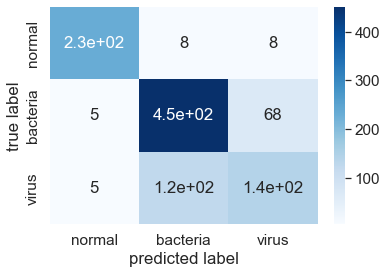

In [56]:
# Confusion matrix:
#   row: Ground truth
#   column: predict
print(confusion_matrix(y_true, y_pred))
labels = ['normal','bacteria','virus']
sns.set(font_scale=1.4)
ax1 = sns.heatmap(confusion_matrix(y_true, y_pred),annot=True, cmap='Blues',xticklabels=labels, yticklabels=labels)
ax1.set_xlabel('predicted label')
ax1.set_ylabel('true label')

In [57]:
# #save model
# model.save('base_model_vgg19.h1')
# #save weights
# model.save_weights('my_model_vgg_19_weights.h1')

#### Make Kaggle Submission

In [58]:
predictions = np.argmax(model.predict(gen_test), axis=-1)

10/10 [==============================] - 39s 4s/step


In [60]:
df = pd.DataFrame()
df['Id'] = [f'{i:03d}.jpeg' for i in range(len(img_paths_test))]
df['Category'] = predictions.astype(int)
df.to_csv('submission21.csv', index=None)
df

,Id,Category
0,000.jpeg,2
1,001.jpeg,1
2,002.jpeg,1
3,003.jpeg,1
4,004.jpeg,0
...,...,...
619,619.jpeg,1
620,620.jpeg,2
621,621.jpeg,0
622,622.jpeg,1
